In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from transformers import (AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, 
                          BertTokenizerFast, XLMRobertaTokenizerFast, T5TokenizerFast, 
                          MT5ForSequenceClassification)
from torch.utils.data import Dataset
import torch
import tqdm

In [2]:
train_df = pd.read_csv('/kaggle/input/caste-and-migration-hate-speech-detection/train.csv')
dev_df = pd.read_csv('/kaggle/input/caste-and-migration-hate-speech-detection/dev.csv')
df = pd.concat([train_df, dev_df], ignore_index=True)

# Drop missing values
df = df.dropna(subset=['text', 'label'])
df.reset_index(drop=True, inplace=True)
df

,id,text,label
0,3268,Indha ariya kandupidippin moolam neenga solla ...,0
1,6239,@vijayakumarp7959 unmai therincha nee pesu,0
2,5859,Inga erukka yella dev... boys vadakkan vadakk...,1
3,3519,பீகாரி பிரசாந்த் கிஷோரிடம் கொடுத்த 350 கோடியை ...,1
4,5136,Mumbai Bangalore la 80% percentage outsiders,1
...,...,...,...
6294,5860,This is done by those who want chaos in Tamil ...,0
6295,1441,"வடமாநிலத்தவருக்கு வேலை வாய்ப்பு கொடுப்பதை ,பணி...",0
6296,3253,நம்ம மேல எந்த தப்பும் இல்லை.... ஏன் என்றால் நா...,0
6297,4295,தம்பி உத்திரபிரதேசம் டெல்லி எல்லையில் உள்ள 90%...,1


In [3]:
train_texts, val_texts, train_labels, val_labels = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

In [4]:
tokenizers = {
    # 'mT5': T5TokenizerFast.from_pretrained('google/mt5-base'),
    'mBERT': BertTokenizerFast.from_pretrained('bert-base-multilingual-cased'),
    'XLM-Roberta': XLMRobertaTokenizerFast.from_pretrained('xlm-roberta-base'),
    'IndicBERT': AutoTokenizer.from_pretrained('ai4bharat/indic-bert'),
    'MuRIL': AutoTokenizer.from_pretrained('google/muril-base-cased')
}

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

In [5]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors="pt")
        # Flatten the tensors to avoid extra dimension
        item = {key: encoding[key].squeeze(0) for key in encoding}
        item['labels'] = torch.tensor(label, dtype=torch.long)
        return item

In [6]:
models = {
    # 'mT5': MT5ForSequenceClassification.from_pretrained('google/mt5-base', num_labels=2),
    'mBERT': AutoModelForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2),
    'XLM-Roberta': AutoModelForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=2),
    'IndicBERT': AutoModelForSequenceClassification.from_pretrained('ai4bharat/indic-bert', num_labels=2),
    'MuRIL': AutoModelForSequenceClassification.from_pretrained('google/muril-base-cased', num_labels=2)
}

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


pytorch_model.bin:   0%|          | 0.00/953M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
from transformers import EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir='/kaggle/results',          # output directory
    num_train_epochs=4,                    # number of training epochs
    per_device_train_batch_size=16,        # batch size for training
    per_device_eval_batch_size=64,         # batch size for evaluation
    warmup_steps=500,                      # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                     # strength of weight decay
    logging_dir='/kaggle/logs',            # directory for storing logs
    logging_steps=10,                      # log training progress every 10 steps
    eval_strategy='epoch',                 # evaluate every epoch
    report_to="none",                      # No reporting to external services (optional)
    fp16=True,                             # Enable mixed precision (use fp16 for faster training)
    dataloader_num_workers=4,              # number of workers for data loading
    no_cuda=False,                         # Ensure CUDA is used (default is True)
    gradient_accumulation_steps=1,         # Use gradient accumulation if needed
    load_best_model_at_end=True,           # Load the best model at the end of training  # Use accuracy to track the best model
    evaluation_strategy='epoch',           # Evaluate every epoch
    save_strategy='epoch',                 # Save model every epoch
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [8]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def train_and_evaluate(model_name, model, tokenizer, train_texts, val_texts, train_labels, val_labels):
    # Prepare datasets
    train_dataset = HateSpeechDataset(train_texts, train_labels, tokenizer)
    val_dataset = HateSpeechDataset(val_texts, val_labels, tokenizer)
    
    # Prepare Trainer object
    trainer = Trainer(
        model=model, 
        args=training_args,
        train_dataset=train_dataset, 
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
    )
    
    trainer.train()
    preds = trainer.predict(val_dataset)
    
    # Post-processing results
    pred_labels = np.argmax(preds.predictions, axis=1)
    acc = accuracy_score(val_labels, pred_labels)
    
    # Print results after training each model
    print(f"Results for {model_name}:")
    print(f"Accuracy: {acc}")
    print(f"Classification Report:\n{classification_report(val_labels, pred_labels)}")
    print(f"Confusion Matrix:\n{confusion_matrix(val_labels, pred_labels)}")
    
    return acc, classification_report(val_labels, pred_labels), confusion_matrix(val_labels, pred_labels)

results = {}

# Loop through models and evaluate with tqdm progress
for model_name in models.keys():
    print(f"Evaluating {model_name}...")
    acc, class_report, conf_matrix = train_and_evaluate(
        model_name, models[model_name], tokenizers[model_name], train_texts, val_texts, train_labels, val_labels
    )
    results[model_name] = {
        'accuracy': acc,
        'classification_report': class_report,
        'confusion_matrix': conf_matrix
    }

<ipython-input-8-872f14456421>:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluating mBERT...


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.674400,0.655633
2,0.604100,0.610849
3,0.504200,0.646126
4,0.322400,0.613337


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

Results for mBERT:
Accuracy: 0.6730158730158731
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.80      0.76       798
           1       0.57      0.45      0.50       462

    accuracy                           0.67      1260
   macro avg       0.64      0.63      0.63      1260
weighted avg       0.66      0.67      0.66      1260

Confusion Matrix:
[[639 159]
 [253 209]]
Evaluating XLM-Roberta...


<ipython-input-8-872f14456421>:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.667200,0.649145
2,0.659300,0.626711
3,0.624500,0.646344
4,0.433500,0.591397


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

Results for XLM-Roberta:
Accuracy: 0.7087301587301588
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       798
           1       0.62      0.53      0.57       462

    accuracy                           0.71      1260
   macro avg       0.68      0.67      0.68      1260
weighted avg       0.70      0.71      0.70      1260

Confusion Matrix:
[[649 149]
 [218 244]]
Evaluating IndicBERT...


<ipython-input-8-872f14456421>:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.672400,0.661078
2,0.658600,0.647324
3,0.642700,0.644251
4,0.582200,0.630944


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

Results for IndicBERT:
Accuracy: 0.6333333333333333
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.75      0.72       798
           1       0.50      0.43      0.46       462

    accuracy                           0.63      1260
   macro avg       0.60      0.59      0.59      1260
weighted avg       0.62      0.63      0.63      1260

Confusion Matrix:
[[598 200]
 [262 200]]
Evaluating MuRIL...


<ipython-input-8-872f14456421>:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.678100,0.667252
2,0.645400,0.642198
3,0.620300,0.603585
4,0.468200,0.545781


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

Results for MuRIL:
Accuracy: 0.7380952380952381
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.81      0.80       798
           1       0.65      0.61      0.63       462

    accuracy                           0.74      1260
   macro avg       0.72      0.71      0.71      1260
weighted avg       0.73      0.74      0.74      1260

Confusion Matrix:
[[649 149]
 [181 281]]


In [9]:
# Optionally, print results
for model_name, result in results.items():
    print(f"Results for {model_name}:")
    print(f"Accuracy: {result['accuracy']}")
    print(f"Classification Report:\n{result['classification_report']}")
    print(f"Confusion Matrix:\n{result['confusion_matrix']}")

Results for mBERT:
Accuracy: 0.6730158730158731
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.80      0.76       798
           1       0.57      0.45      0.50       462

    accuracy                           0.67      1260
   macro avg       0.64      0.63      0.63      1260
weighted avg       0.66      0.67      0.66      1260

Confusion Matrix:
[[639 159]
 [253 209]]
Results for XLM-Roberta:
Accuracy: 0.7087301587301588
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       798
           1       0.62      0.53      0.57       462

    accuracy                           0.71      1260
   macro avg       0.68      0.67      0.68      1260
weighted avg       0.70      0.71      0.70      1260

Confusion Matrix:
[[649 149]
 [218 244]]
Results for IndicBERT:
Accuracy: 0.6333333333333333
Classification Report:
              precision    recall  f1-sco

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


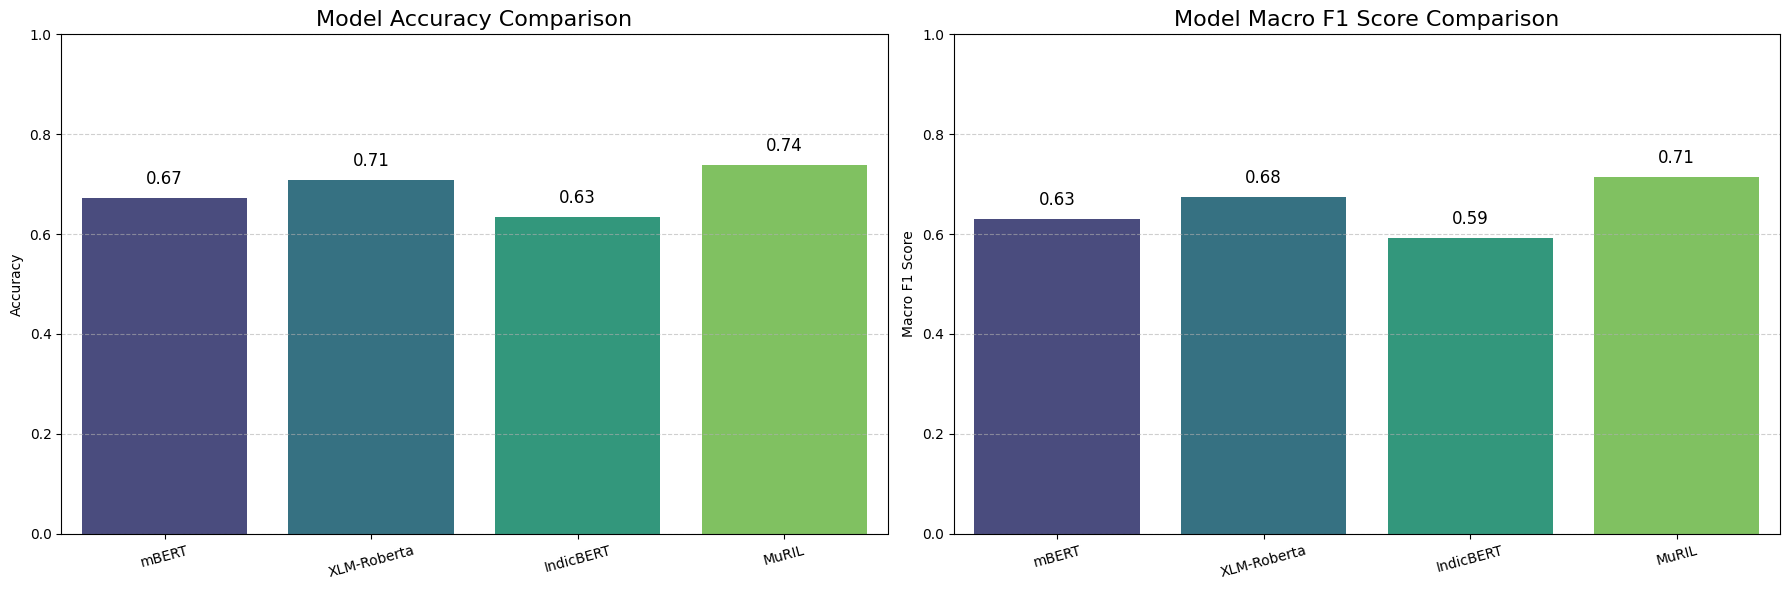

Results for mBERT:
Accuracy: 0.6730158730158731
Macro F1 Score: 0.63
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.80      0.76       798
           1       0.57      0.45      0.50       462

    accuracy                           0.67      1260
   macro avg       0.64      0.63      0.63      1260
weighted avg       0.66      0.67      0.66      1260

Confusion Matrix:
[[639 159]
 [253 209]]
Results for XLM-Roberta:
Accuracy: 0.7087301587301588
Macro F1 Score: 0.68
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       798
           1       0.62      0.53      0.57       462

    accuracy                           0.71      1260
   macro avg       0.68      0.67      0.68      1260
weighted avg       0.70      0.71      0.70      1260

Confusion Matrix:
[[649 149]
 [218 244]]
Results for IndicBERT:
Accuracy: 0.6333333333333333
Macro F1 Score: 0.59
C

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Function to compute macro F1 score from confusion matrix
def compute_macro_f1(conf_matrix):
    # Calculate precision, recall, and F1 score for each class
    # Precision for each class
    precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
    # Recall for each class
    recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    # F1 score for each class
    f1 = 2 * (precision * recall) / (precision + recall)
    # Return the macro F1 score (average of individual F1 scores)
    return np.nanmean(f1)  # Use np.nanmean to ignore NaN values (for undefined classes)

# 1️⃣ Plot Accuracy and Macro F1 Score Comparison
model_names = list(results.keys())
accuracies = [results[m]['accuracy'] for m in model_names]
macro_f1_scores = []

# Calculate macro F1 score for each model
for model_name in model_names:
    conf_matrix = results[model_name]['confusion_matrix']
    macro_f1 = compute_macro_f1(conf_matrix)
    macro_f1_scores.append(macro_f1)

# Create a figure with two subplots (Accuracy and Macro F1 Score)
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Plot Accuracy
sns.barplot(x=model_names, y=accuracies, palette='viridis', ax=ax[0])
ax[0].set_title("Model Accuracy Comparison", fontsize=16)
ax[0].set_ylabel("Accuracy")
ax[0].set_ylim(0, 1.0)
ax[0].set_xticklabels(model_names, rotation=15)
ax[0].grid(axis='y', linestyle='--', alpha=0.6)

# Add accuracy values on the bars
for i, acc in enumerate(accuracies):
    ax[0].text(i, acc + 0.02, f'{acc:.2f}', ha='center', va='bottom', fontsize=12)

# Plot Macro F1 Score
sns.barplot(x=model_names, y=macro_f1_scores, palette='viridis', ax=ax[1])
ax[1].set_title("Model Macro F1 Score Comparison", fontsize=16)
ax[1].set_ylabel("Macro F1 Score")
ax[1].set_ylim(0, 1.0)
ax[1].set_xticklabels(model_names, rotation=15)
ax[1].grid(axis='y', linestyle='--', alpha=0.6)

# Add F1 score values on the bars
for i, f1 in enumerate(macro_f1_scores):
    ax[1].text(i, f1 + 0.02, f'{f1:.2f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

# Optionally, print results
for model_name, result in results.items():
    print(f"Results for {model_name}:")
    print(f"Accuracy: {result['accuracy']}")
    print(f"Macro F1 Score: {macro_f1_scores[model_names.index(model_name)]:.2f}")
    print(f"Classification Report:\n{result['classification_report']}")
    print(f"Confusion Matrix:\n{result['confusion_matrix']}")


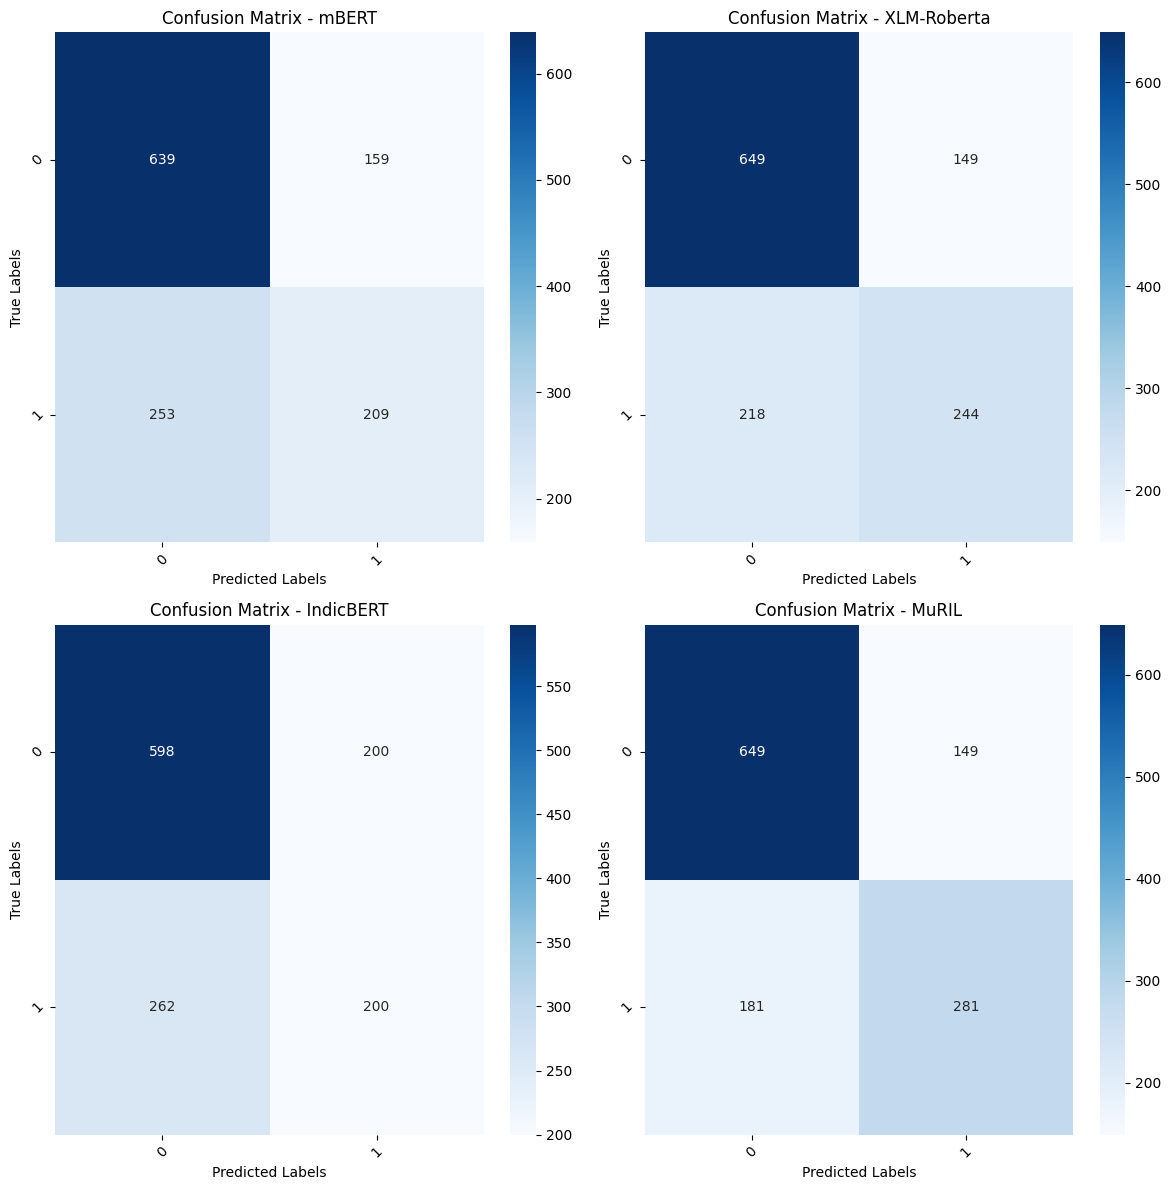

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Number of models
num_models = len(model_names)

# Calculate the number of rows and columns for the grid
num_rows = (num_models + 1) // 2  # Round up for odd numbers of models
num_cols = 2  # We will display the confusion matrices in 2 columns

# Create a figure for all confusion matrices
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))

# Flatten the axes array in case it's 2D for easy iteration
axes = axes.flatten()

for idx, model_name in enumerate(model_names):
    conf_matrix = results[model_name]['confusion_matrix']
    
    # Plotting each confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f"Confusion Matrix - {model_name}")
    axes[idx].set_xlabel("Predicted Labels")
    axes[idx].set_ylabel("True Labels")
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
    axes[idx].set_yticklabels(axes[idx].get_yticklabels(), rotation=45)

# Remove any unused axes if the number of models is odd
for idx in range(num_models, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()